## Importing libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Importing data

In [2]:
data = pd.read_excel('ALF_Data.xlsx')
data.head()

,Age,Gender,Region,Weight,Height,Body Mass Index,Obesity,Waist,Maximum Blood Pressure,Minimum Blood Pressure,...,PoorVision,Alcohol Consumption,HyperTension,Family HyperTension,Diabetes,Family Diabetes,Hepatitis,Family Hepatitis,Chronic Fatigue,ALF
0,65,M,east,56.0,162.1,21.31,0.0,83.6,135.0,71.0,...,0.0,1,0.0,0,0.0,1,1.0,0.0,0.0,0.0
1,36,M,south,60.2,162.2,22.88,0.0,76.6,96.0,52.0,...,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0
2,66,M,east,83.9,162.5,31.77,1.0,113.2,115.0,57.0,...,0.0,1,0.0,0,1.0,0,0.0,0.0,0.0,0.0
3,54,M,east,69.4,160.5,26.94,0.0,77.9,110.0,57.0,...,0.0,1,0.0,0,0.0,0,0.0,0.0,0.0,0.0
4,63,M,north,73.1,159.2,28.84,0.0,89.3,132.0,73.0,...,0.0,0,1.0,0,0.0,0,0.0,0.0,0.0,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8785 entries, 0 to 8784
Data columns (total 30 columns):
Age                       8785 non-null int64
Gender                    8785 non-null object
Region                    8785 non-null object
Weight                    8591 non-null float64
Height                    8594 non-null float64
Body Mass Index           8495 non-null float64
Obesity                   8495 non-null float64
Waist                     8471 non-null float64
Maximum Blood Pressure    8481 non-null float64
Minimum Blood Pressure    8409 non-null float64
Good Cholesterol          8768 non-null float64
Bad Cholesterol           8767 non-null float64
Total Cholesterol         8769 non-null float64
Dyslipidemia              8785 non-null int64
PVD                       8785 non-null int64
Physical Activity         8775 non-null float64
Education                 8765 non-null float64
Unmarried                 8333 non-null float64
Income                    7624 non-nu

## Data cleaning

In [4]:
#Finding null values

data.isnull().sum()

Age                          0
Gender                       0
Region                       0
Weight                     194
Height                     191
Body Mass Index            290
Obesity                    290
Waist                      314
Maximum Blood Pressure     304
Minimum Blood Pressure     376
Good Cholesterol            17
Bad Cholesterol             18
Total Cholesterol           16
Dyslipidemia                 0
PVD                          0
Physical Activity           10
Education                   20
Unmarried                  452
Income                    1161
Source of Care               0
PoorVision                 563
Alcohol Consumption          0
HyperTension                80
Family  HyperTension         0
Diabetes                     2
Family Diabetes              0
Hepatitis                   22
Family Hepatitis             6
Chronic Fatigue             35
ALF                       2785
dtype: int64

In [5]:
#Since ALF is the key variable in the dataset we drop rows with null values for ALF

data = data.loc[data['ALF'].notnull()]
data.isnull().sum()

Age                         0
Gender                      0
Region                      0
Weight                    133
Height                    139
Body Mass Index           206
Obesity                   206
Waist                     215
Maximum Blood Pressure    206
Minimum Blood Pressure    252
Good Cholesterol            8
Bad Cholesterol             8
Total Cholesterol           6
Dyslipidemia                0
PVD                         0
Physical Activity           8
Education                  15
Unmarried                 301
Income                    792
Source of Care              0
PoorVision                376
Alcohol Consumption         0
HyperTension               53
Family  HyperTension        0
Diabetes                    1
Family Diabetes             0
Hepatitis                  13
Family Hepatitis            3
Chronic Fatigue            26
ALF                         0
dtype: int64

In [6]:
# Columns with continuous variables: replace null values with column mean
# The maximum number of nulls in continuous variables is 252 from 6000, so we are not changing 
# the distributions very much.

cont_var = ['Weight', 'Height', 'Body Mass Index', 'Waist', 'Maximum Blood Pressure', 
            'Minimum Blood Pressure', 'Good Cholesterol', 'Bad Cholesterol', 'Total Cholesterol']

for col in cont_var:
    data[col] = data[col].fillna(data[col].mean())
    
data.isnull().sum()

Age                         0
Gender                      0
Region                      0
Weight                      0
Height                      0
Body Mass Index             0
Obesity                   206
Waist                       0
Maximum Blood Pressure      0
Minimum Blood Pressure      0
Good Cholesterol            0
Bad Cholesterol             0
Total Cholesterol           0
Dyslipidemia                0
PVD                         0
Physical Activity           8
Education                  15
Unmarried                 301
Income                    792
Source of Care              0
PoorVision                376
Alcohol Consumption         0
HyperTension               53
Family  HyperTension        0
Diabetes                    1
Family Diabetes             0
Hepatitis                  13
Family Hepatitis            3
Chronic Fatigue            26
ALF                         0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 30 columns):
Age                       6000 non-null int64
Gender                    6000 non-null object
Region                    6000 non-null object
Weight                    6000 non-null float64
Height                    6000 non-null float64
Body Mass Index           6000 non-null float64
Obesity                   5794 non-null float64
Waist                     6000 non-null float64
Maximum Blood Pressure    6000 non-null float64
Minimum Blood Pressure    6000 non-null float64
Good Cholesterol          6000 non-null float64
Bad Cholesterol           6000 non-null float64
Total Cholesterol         6000 non-null float64
Dyslipidemia              6000 non-null int64
PVD                       6000 non-null int64
Physical Activity         5992 non-null float64
Education                 5985 non-null float64
Unmarried                 5699 non-null float64
Income                    5208 non-nu

In [8]:
#ALF is a categorical variable but it is float64
#Changing all dichotomous discrete variable to categorical

data[['Dyslipidemia', 'PVD', 'Physical Activity', 'Education', 'Unmarried',
       'Income', 'Source of Care', 'PoorVision', 'Alcohol Consumption',
       'HyperTension', 'Family  HyperTension', 'Diabetes', 'Family Diabetes',
       'Hepatitis', 'Family Hepatitis', 'Chronic Fatigue', 'ALF']] = data[['Dyslipidemia', 'PVD', 'Physical Activity', 'Education', 'Unmarried',
       'Income', 'Source of Care', 'PoorVision', 'Alcohol Consumption',
       'HyperTension', 'Family  HyperTension', 'Diabetes', 'Family Diabetes',
       'Hepatitis', 'Family Hepatitis', 'Chronic Fatigue', 'ALF']].astype('category')


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 30 columns):
Age                       6000 non-null int64
Gender                    6000 non-null object
Region                    6000 non-null object
Weight                    6000 non-null float64
Height                    6000 non-null float64
Body Mass Index           6000 non-null float64
Obesity                   5794 non-null float64
Waist                     6000 non-null float64
Maximum Blood Pressure    6000 non-null float64
Minimum Blood Pressure    6000 non-null float64
Good Cholesterol          6000 non-null float64
Bad Cholesterol           6000 non-null float64
Total Cholesterol         6000 non-null float64
Dyslipidemia              6000 non-null category
PVD                       6000 non-null category
Physical Activity         5992 non-null category
Education                 5985 non-null category
Unmarried                 5699 non-null category
Income                    52

In [10]:
# Extracting a random sample of 10 patients to test a prediction model later

sample = data.sample(10)
sample

,Age,Gender,Region,Weight,Height,Body Mass Index,Obesity,Waist,Maximum Blood Pressure,Minimum Blood Pressure,...,PoorVision,Alcohol Consumption,HyperTension,Family HyperTension,Diabetes,Family Diabetes,Hepatitis,Family Hepatitis,Chronic Fatigue,ALF
4979,52,F,east,95.4,177.6,30.25,1.0,113.3,145.0,88.0,...,0.0,0,1.0,1,0.0,0,0.0,0.0,0.0,0.0
2745,62,M,north,82.5,152.5,35.47,1.0,106.7,161.0,72.0,...,0.0,0,1.0,0,1.0,1,0.0,0.0,0.0,0.0
2786,30,M,north,74.2,152.9,31.74,1.0,84.4,120.0,65.0,...,0.0,0,0.0,1,0.0,1,0.0,0.0,0.0,0.0
487,51,M,south,80.9,155.9,33.29,1.0,92.4,129.0,78.0,...,0.0,0,1.0,0,0.0,0,0.0,0.0,0.0,0.0
191,61,F,south,97.1,171.0,33.21,1.0,114.3,132.0,88.0,...,0.0,1,0.0,0,0.0,1,0.0,0.0,0.0,0.0
1125,22,M,east,57.6,166.7,20.73,0.0,79.9,93.0,66.0,...,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0
352,29,F,south,63.9,162.3,24.26,0.0,81.9,119.0,67.0,...,1.0,0,NaN,1,0.0,0,0.0,0.0,0.0,0.0
3722,63,M,east,115.8,164.4,42.85,1.0,121.3,146.0,81.0,...,0.0,1,1.0,0,1.0,0,0.0,0.0,0.0,0.0
3013,66,F,east,76.3,167.2,27.29,0.0,100.4,145.0,79.0,...,0.0,0,1.0,0,0.0,0,0.0,0.0,0.0,0.0
5626,52,F,east,83.4,175.9,26.95,0.0,96.6,105.0,60.0,...,0.0,1,0.0,1,0.0,1,0.0,0.0,0.0,0.0


In [11]:
#Dropping the sample population from dataframe

data = data.drop(sample.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5990 entries, 0 to 5999
Data columns (total 30 columns):
Age                       5990 non-null int64
Gender                    5990 non-null object
Region                    5990 non-null object
Weight                    5990 non-null float64
Height                    5990 non-null float64
Body Mass Index           5990 non-null float64
Obesity                   5784 non-null float64
Waist                     5990 non-null float64
Maximum Blood Pressure    5990 non-null float64
Minimum Blood Pressure    5990 non-null float64
Good Cholesterol          5990 non-null float64
Bad Cholesterol           5990 non-null float64
Total Cholesterol         5990 non-null float64
Dyslipidemia              5990 non-null category
PVD                       5990 non-null category
Physical Activity         5982 non-null category
Education                 5975 non-null category
Unmarried                 5689 non-null category
Income                    51

## Correlations

In [12]:
corr_df = data.corr()
corr_df

,Age,Weight,Height,Body Mass Index,Obesity,Waist,Maximum Blood Pressure,Minimum Blood Pressure,Good Cholesterol,Bad Cholesterol,Total Cholesterol
Age,1.000000,-0.050195,-0.141578,0.025648,0.005862,0.166377,0.550398,0.020138,0.040747,0.136373,0.152750
Weight,-0.050195,1.000000,0.456308,0.855897,0.661632,0.861279,0.046568,0.170839,-0.311057,0.132575,0.017403
Height,-0.141578,0.456308,1.000000,-0.034628,-0.055528,0.191134,-0.101888,0.156068,-0.195237,-0.033014,-0.106174
Body Mass Index,0.025648,0.855897,-0.034628,1.000000,0.780646,0.859126,0.112654,0.105968,-0.239101,0.159516,0.071403
Obesity,0.005862,0.661632,-0.055528,0.780646,1.000000,0.677534,0.079867,0.090535,-0.181594,0.122148,0.055312
Waist,0.166377,0.861279,0.191134,0.859126,0.677534,1.000000,0.172664,0.121714,-0.304063,0.229652,0.117754
Maximum Blood Pressure,0.550398,0.046568,-0.101888,0.112654,0.079867,0.172664,1.000000,0.341815,0.014661,0.139339,0.145992
Minimum Blood Pressure,0.020138,0.170839,0.156068,0.105968,0.090535,0.121714,0.341815,1.000000,-0.080861,0.124815,0.095056
Good Cholesterol,0.040747,-0.311057,-0.195237,-0.239101,-0.181594,-0.304063,0.014661,-0.080861,1.000000,-0.205385,0.167563
Bad Cholesterol,0.136373,0.132575,-0.033014,0.159516,0.122148,0.229652,0.139339,0.124815,-0.205385,1.000000,0.930302


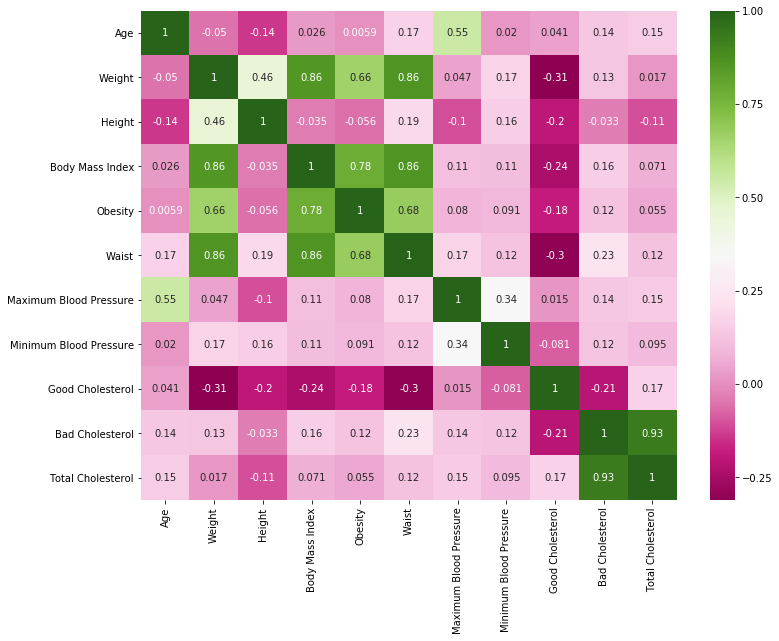

In [13]:
#Hetmap with correlations

plt.figure(figsize=(12,9))
sns.heatmap(corr_df, annot=True, cmap="PiYG")
plt.show()

The variables with higher correlation, as expected, are the ones related to body weight between them: Weight, BMI, Waist, ... <br>
Also Bad cholesterol with total cholesterol.

## Comparison of variables between ALF patients vs no ALF

In [14]:
# I am choosing 3 variables of interest to analyze. 
# My choice: Age, Hepatitis and Maximum Blood Pressure

## Comparing Age between patients with ALF vs no ALF

In [15]:
# Creating a dataframe with Age and ALF columns only

age_df = data[['Age', 'ALF']]
age_df.head()

,Age,ALF
0,65,0.0
1,36,0.0
2,66,0.0
3,54,0.0
4,63,0.0


C:\Users\marcm\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


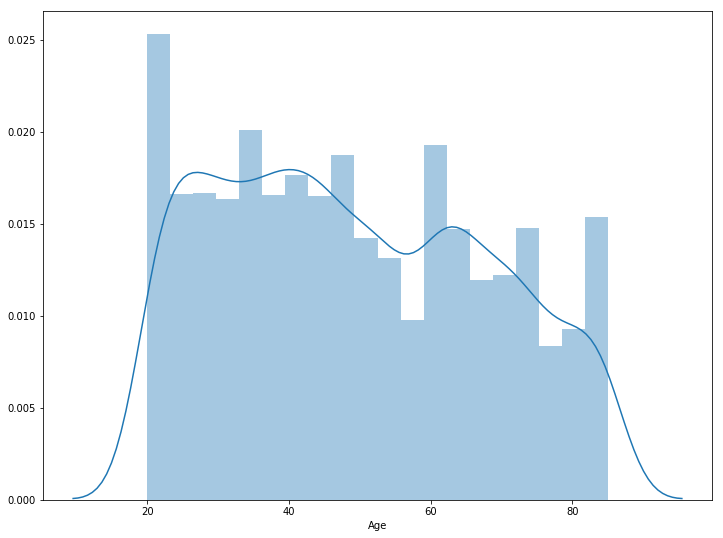

In [16]:
# Plotting the distribution of the variable Age

plt.figure(figsize=(12,9))
sns.distplot(age_df['Age'])
plt.show()

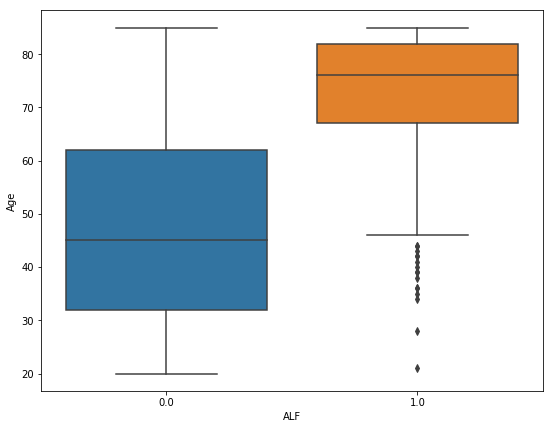

In [17]:
# Plotting the boxplots of the variable Age according to ALF

plt.figure(figsize=(9,7))
sns.boxplot(x='ALF', y='Age', data=age_df)
plt.show()

In [18]:
# Splitting ages for ALF positive and negative patients

age1 = age_df.loc[age_df['ALF']==1]
age0 = age_df.loc[age_df['ALF']==0]

In [19]:
# Comparing value of Age for ALF positive and negative patients with t-test for independent groups
# H0: ALF positive average Age = ALF negative average Age
# H1: ALF positive average Age != ALF negative average Age

from scipy.stats import ttest_ind

print('Test results: ', ttest_ind(age1['Age'], age0['Age'], equal_var=True))

# The p-value is lower than 0.05, so the mean of Age for ALF positive patients VS ALF negative is different.

Test results:  Ttest_indResult(statistic=30.611844455603652, pvalue=2.4891313474890105e-191)


## Comparing Hepatitis between patients with ALF vs no ALF

In [20]:
# Reducing the dataframe to ALF, Hepatitis and another column that will be used to count patients after grouping them

hep_df = data[['ALF','Hepatitis', 'Gender']]
hep_df.head()

,ALF,Hepatitis,Gender
0,0.0,1.0,M
1,0.0,0.0,M
2,0.0,0.0,M
3,0.0,0.0,M
4,0.0,0.0,M


In [21]:
#Grouping patients according to ALF and Hepatitis and counting them

grouped = hep_df.groupby(['ALF', 'Hepatitis'], as_index=False).count()
grouped = grouped.rename(columns={'Gender':'Count'})
grouped

,ALF,Hepatitis,Count
0,0.0,0.0,5239
1,0.0,1.0,275
2,1.0,0.0,348
3,1.0,1.0,115


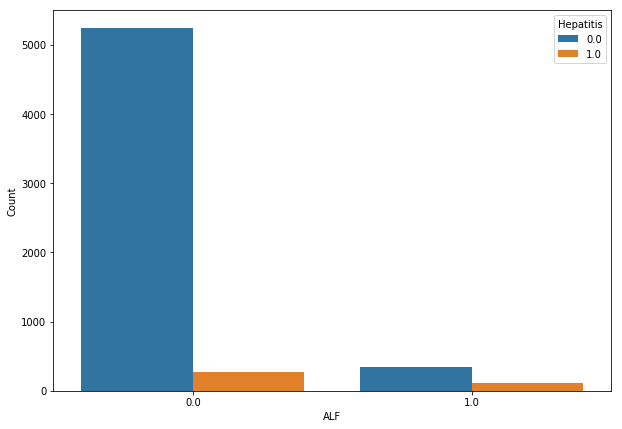

In [22]:
# Plotting the barplot of the variable Hepatitis according to ALF

plt.figure(figsize=(10,7))
sns.barplot(data=grouped, x='ALF', y='Count', hue='Hepatitis')
plt.show()

In [23]:
# As we have two dichotomous variables we will perform a Chi-square test
# Creating the contingency table

data_crosstab = pd.crosstab(data['Hepatitis'], 
                            data['ALF'], margins = False) 
data_crosstab

ALF,0.0,1.0
Hepatitis,,
0.0,5239,348
1.0,275,115


In [24]:
# Chi-square test
# H0: Percentage of patients with Hepatitis with ALF = Percentage of patients with Hepatitis without ALF
# H1: Percentage of patients with Hepatitis with ALF != Percentage of patients with Hepatitis without ALF

from scipy.stats import chi2_contingency

chi2, p, dof, ex = chi2_contingency(data_crosstab, correction=False)
print('p-value= ', p)

# P-value is lower than 0.05, patients with Hepatitis are differently distributed in patients with ALF vs no ALF.

p-value=  5.713364434830529e-62


## Compare Maximum Blood Pressure between ALF vs no ALF

In [25]:
# Creating a dataframe with Max Blood Pressure and ALF columns only

mbp_df = data[['Maximum Blood Pressure', 'ALF']]
mbp_df.head()

,Maximum Blood Pressure,ALF
0,135.0,0.0
1,96.0,0.0
2,115.0,0.0
3,110.0,0.0
4,132.0,0.0


C:\Users\marcm\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


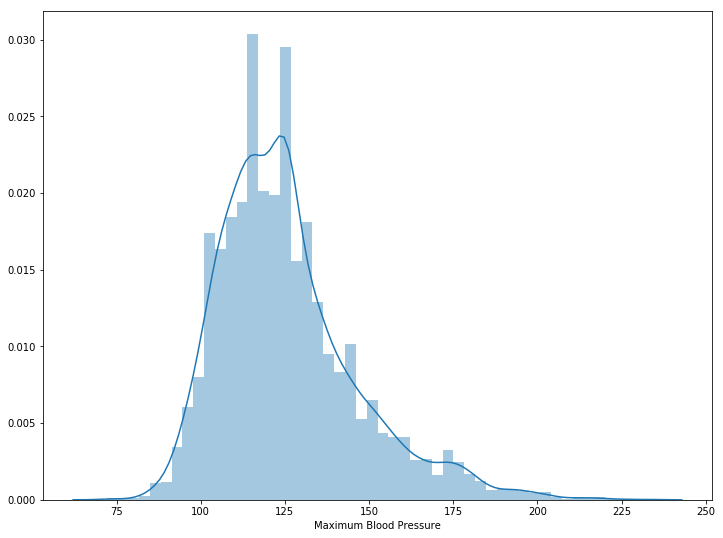

In [26]:
# Plotting the distribution of the variable Max Blood Pressure

plt.figure(figsize=(12,9))
sns.distplot(mbp_df['Maximum Blood Pressure'])
plt.show()

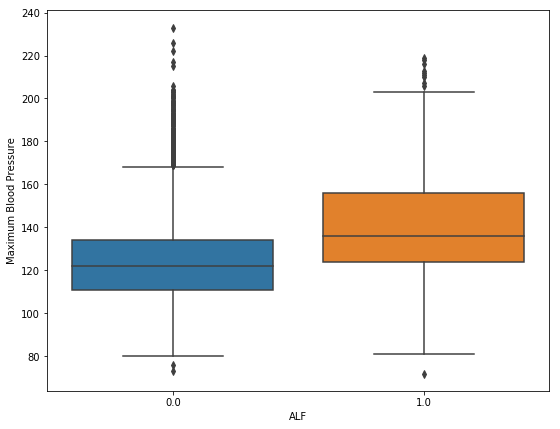

In [27]:
# Plotting the boxplots of the variable Max Blood Pressure according to ALF

plt.figure(figsize=(9,7))
sns.boxplot(x='ALF', y='Maximum Blood Pressure', data=mbp_df)
plt.show()

In [28]:
# Splitting ages for ALF positive and negative patients

mbp1 = mbp_df.loc[mbp_df['ALF']==1]
mbp0 = mbp_df.loc[mbp_df['ALF']==0]

In [29]:
# Comparing value of Max Blood Pressure for ALF positive and negative patients with t-test for independent groups
# H0: ALF positive average Max Blood Pressure = ALF negative average Max Blood Pressure
# H1: ALF positive average Max Blood Pressure != ALF negative average Max Blood Pressure

from scipy.stats import ttest_ind

print('Test results: ', ttest_ind(mbp1['Maximum Blood Pressure'], mbp0['Maximum Blood Pressure'], equal_var=True))

# The p-value is lower than 0.05, so the mean of Maximum Blood Pressure for ALF positive patients VS ALF negative is different.

Test results:  Ttest_indResult(statistic=16.77327100314878, pvalue=9.6548767862889e-62)


## Principal Components Analysis to predict ALF

In [30]:
from sklearn.decomposition import PCA

numericData = data[['Age','Weight', 'Height', 'Body Mass Index',
       'Waist', 'Maximum Blood Pressure', 'Minimum Blood Pressure',
       'Good Cholesterol', 'Bad Cholesterol', 'Total Cholesterol']] 

pca = PCA(n_components=4) 
principalComponents = pca.fit_transform(np.array(numericData))

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])


principalDf.head() 

,PC 1,PC 2,PC 3,PC 4
0,133.352677,-28.314308,11.313558,-19.834752
1,-43.440325,-20.958698,-28.358993,-32.302143
2,78.206943,7.204427,-7.495193,-4.218135
3,18.271264,-34.662197,-2.735114,15.710755
4,13.698200,-14.349703,18.113559,10.610815


In [31]:
#Calculating percentage of variance explained by the 4 components

sum(pca.explained_variance_ratio_)

0.9224086268074104

## Logistic Regression and testing new people to predict ALF

In [37]:
from sklearn.linear_model import LogisticRegression

numericData = data[['Age','Weight', 'Height', 'Body Mass Index',
       'Waist', 'Maximum Blood Pressure', 'Minimum Blood Pressure',
       'Good Cholesterol', 'Bad Cholesterol', 'Total Cholesterol']] 


target = data['ALF'] 
model = LogisticRegression()
classification = model.fit(numericData, target)

classification.get_params()

C:\Users\marcm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [40]:
classification.classes_

array([0., 1.])

In [38]:
sample_test = sample[['Age','Weight', 'Height', 'Body Mass Index',
       'Waist', 'Maximum Blood Pressure', 'Minimum Blood Pressure',
       'Good Cholesterol', 'Bad Cholesterol', 'Total Cholesterol']]

classification.predict(sample_test)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [34]:
sample['ALF']

4979    0.0
2745    0.0
2786    0.0
487     0.0
191     0.0
1125    0.0
352     0.0
3722    0.0
3013    0.0
5626    0.0
Name: ALF, dtype: category
Categories (2, float64): [0.0, 1.0]

In [35]:
# The logistic regression model correctly predicted the ALF outcome in the patients from the extracted sample